In [4]:
import os
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import re


# Enable MPS fallback for operations not supported on the GPU
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Select device: use MPS (Metal Performance Shaders) if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")



Using device: mps


In [5]:
# Loading in CSV file that was scraped into Pandas DataFrame
filepath = '/Users/jonathanermias/Documents/GitHub/RedditStocks_v2.0/data/reddit_stock_scrape20250418_165024.csv'
reddit_data = pd.read_csv(filepath)

try:
    reddit_data['created_utc']= pd.to_datetime(reddit_data['created_utc'], format='%Y-%m-%d %H:%M:%S')
except:
    print("error")

reddit_data['date_only'] = reddit_data['created'].dt.date
                                          
# Combined Clean title and Body text
reddit_data['combined_text'] = reddit_data['clean_title'].fillna('') + ' ' + reddit_data['clean_selftext'].fillna('')


error


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# Initialiing Sentiment analyzers
vader = SentimentIntensityAnalyzer()
bert_model = "ProsusAI/finbert"
nlp = pipeline(task='sentiment-analysis', model=bert_model, tokenizer=bert_model, device=device, torch_dtype=torch.float32)


In [ ]:
def computer_vader_sentiment(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {'neg':0, 'neu': 1, 'pos':0, 'compound': 0}
    return vader.polarity_scores(text)


def compute_finbert_sentiment(texts):
    """Processing texts in batches to speed up FinBERT analysis.
    Returns a list of sentiment results (each a dict with keys 'label' and 'score'),
    with the same length and order as the input list.
    """
    if not texts:
        return []
    
    # Initialize results with None for every text
    results = [None] * len(texts)
    valid_indices = []
    valid_texts = []
    
    # For each text, if it's empty, assign a default result,
    # otherwise record its index and process the text.
    for i, text in enumerate(texts):
        if not isinstance(text, str) or len(text.strip()) == 0:
            results[i] = {'label': 'neutral', 'score': 1.0}
        else:
            valid_indices.append(i)
            valid_texts.append(text[:512])  # truncate to 512 characters
    
    # Process valid texts in batches
    batch_size = 16
    for i in range(0, len(valid_texts), batch_size):
        batch = valid_texts[i:i+batch_size]
        batch_results = nlp(batch)
        
        # Place each result into its original position
        for j, result in enumerate(batch_results):
            idx = valid_indices[i + j]
            results[idx] = result
    
    return results

def normalize_sentiment(score, min_score=-1, max_score=1):
    """Normalize sentiment score to the range [0, 1]."""
    return (score - min_score) / (max_score - min_score) * 100




In [ ]:
# Process the data with both models
print("Computing VADER sentiment...")
title_vader = reddit_data['clean_title'].apply(compute_vader_sentiment)
post_vader = reddit_data['clean_selftext'].apply(compute_vader_sentiment)

# Extract compound scores
reddit_data['title_sentiment_vader'] = title_vader.apply(lambda x: x['compound'])
reddit_data['post_sentiment_vader'] = post_vader.apply(lambda x: x['compound'])

# Process FinBERT in batches for efficiency
print("Computing FinBERT sentiment for titles...")
title_finbert = compute_finbert_sentiment(reddit_data['clean_title'].tolist())
print("Computing FinBERT sentiment for posts...")
post_finbert = compute_finbert_sentiment(reddit_data['clean_selftext'].tolist())

# Process FinBERT results
reddit_data['title_sentiment_finbert'] = [
    finbert['score'] if finbert['label'] == 'positive' else 
    -finbert['score'] if finbert['label'] == 'negative' else 0
    for finbert in title_finbert
]

reddit_data['post_sentiment_finbert'] = [
    finbert['score'] if finbert['label'] == 'positive' else 
    -finbert['score'] if finbert['label'] == 'negative' else 0
    for finbert in post_finbert
]

# Calculate weighted sentiment scores
# Title is weighted more heavily (3:1) as it often contains the main sentiment
reddit_data['title_weight'] = 0.75
reddit_data['post_weight'] = 0.25

# Set post_weight to 0 if post is empty
mask = reddit_data['clean_selftext'].isna() | (reddit_data['clean_selftext'] == '')
reddit_data.loc[mask, 'post_weight'] = 0
reddit_data.loc[mask, 'title_weight'] = 1

# Calculate combined scores for each model
reddit_data['vader_score'] = (reddit_data['title_sentiment_vader'] * reddit_data['title_weight'] + 
                    reddit_data['post_sentiment_vader'] * reddit_data['post_weight'])

reddit_data['finbert_score'] = (reddit_data['title_sentiment_finbert'] * reddit_data['title_weight'] + 
                      reddit_data['post_sentiment_finbert'] * reddit_data['post_weight'])

# Calculate ensemble score (average of both models)
reddit_data['sentiment_score'] = (reddit_data['vader_score'] + reddit_data['finbert_score']) / 2

# Normalize to 0-100 scale for easier interpretation
reddit_data['sentiment_normalized'] = normalize_sentiment(reddit_data['sentiment_score'])

# Add sentiment categories
def categorize_sentiment(score):
    if score < -0.5:
        return 'very_negative'
    elif score < -0.1:
        return 'negative'
    elif score <= 0.1:
        return 'neutral'
    elif score <= 0.5:
        return 'positive'
    else:
        return 'very_positive'

reddit_data['sentiment_category'] = reddit_data['sentiment_score'].apply(categorize_sentiment)

# Calculate sentiment metrics per ticker
if 'mentioned_tickers' in reddit_data.columns:
    # Extract all unique tickers
    all_tickers = set()
    for tickers in reddit_data['mentioned_tickers'].dropna():
        if isinstance(tickers, str):
            all_tickers.update(tickers.split(','))
    
    ticker_sentiment = {}
    for ticker in all_tickers:
        # Find posts mentioning this ticker
        ticker_mask = reddit_data['mentioned_tickers'].fillna('').str.contains(ticker)
        if ticker_mask.sum() > 0:
            ticker_sentiment[ticker] = {
                'count': ticker_mask.sum(),
                'avg_sentiment': reddit_data.loc[ticker_mask, 'sentiment_score'].mean(),
                'avg_normalized': reddit_data.loc[ticker_mask, 'sentiment_normalized'].mean(),
                'sentiment_distribution': reddit_data.loc[ticker_mask, 'sentiment_category'].value_counts().to_dict()
            }
    
    # Convert to DataFrame for easier analysis
    ticker_reddit_data = pd.DataFrame.from_dict(ticker_sentiment, orient='index')
    print(f"Sentiment analysis complete for {len(ticker_reddit_data)} tickers")

# Drop columns that are not needed for modeling
drop_cols = [
    'title', 'selftext',               # raw text
    'clean_title', 'clean_selftext',   # intermediate cleaned text
    'combined_text'                    # only used for computing sentiment
]
reddit_data = reddit_data.drop(columns=[c for c in drop_cols if c in reddit_data.columns])

# Save to CSV
print("Remaining columns for modeling:", reddit_data.columns.tolist())
reddit_data.to_csv('/Users/jonathanermias/Documents/GitHub/RedditStocks_v2.0/data/redditsentiment.csv', index=False)
if 'mentioned_tickers' in reddit_data.columns:
    ticker_reddit_data.to_csv('/Users/jonathanermias/Documents/GitHub/RedditStocks_v2.0/data/ticker_sentiment.csv')

# Display summary
print("\nSentiment Summary:")
print(f"Total posts analyzed: {len(reddit_data)}")
print("\nOverall sentiment distribution:")
print(reddit_data['sentiment_category'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

# Display sample results
print("\nSample results (5 random rows):")
sample_cols = ['clean_title', 'sentiment_score', 'sentiment_normalized', 'sentiment_category']
if 'mentioned_tickers' in reddit_data.columns:
    sample_cols.append('mentioned_tickers')
print(reddit_data[sample_cols].sample(5))

Computing VADER sentiment...


NameError: name 'reddit_data' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

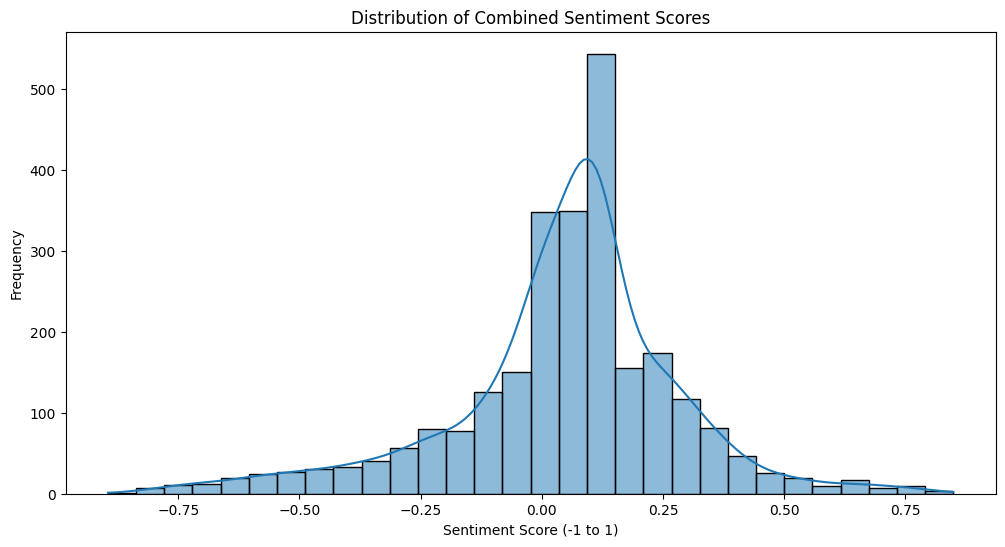

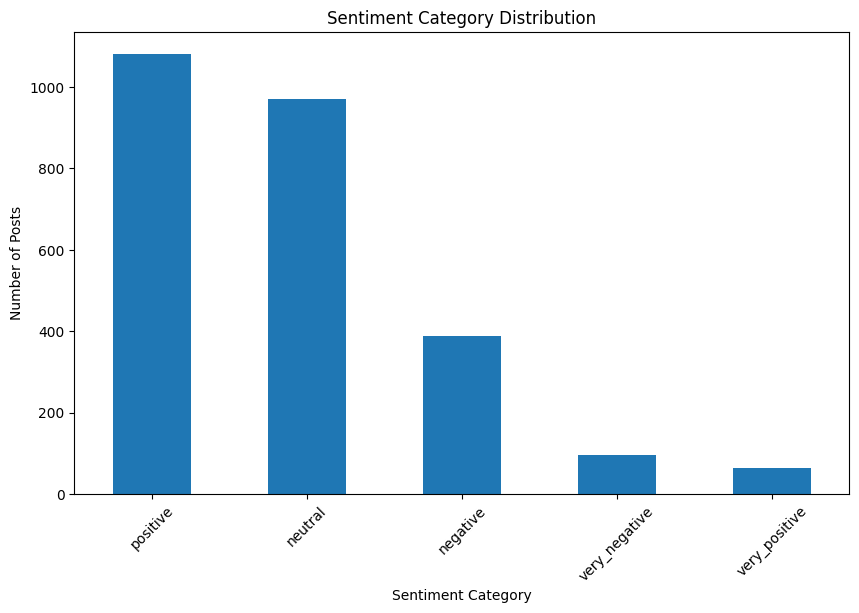

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(reddit_data['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Combined Sentiment Scores')
plt.xlabel('Sentiment Score (-1 to 1)')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
reddit_data['sentiment_category'].value_counts().plot(kind='bar')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

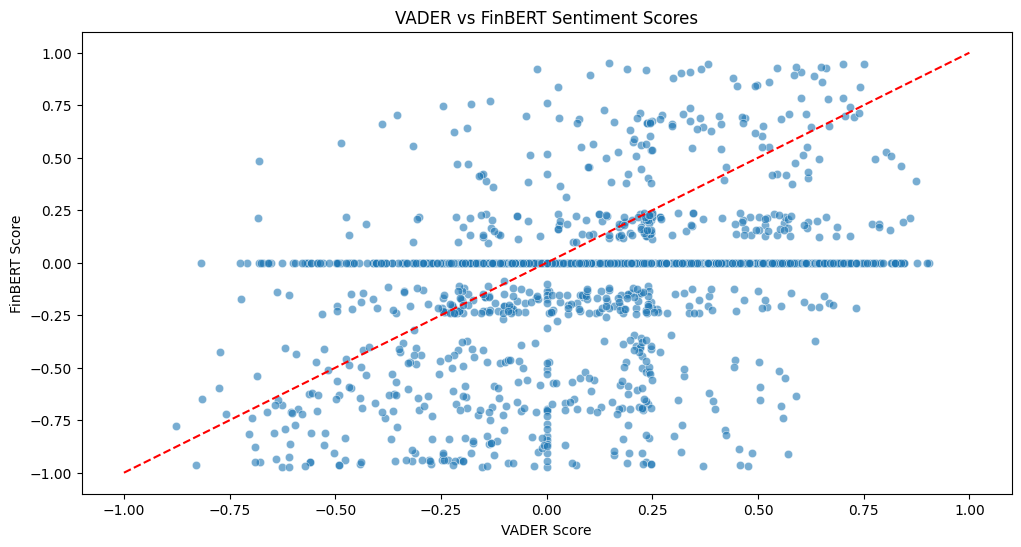

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='vader_score', y='finbert_score', data=reddit_data, alpha=0.6)
plt.title('VADER vs FinBERT Sentiment Scores')
plt.xlabel('VADER Score')
plt.ylabel('FinBERT Score')
plt.plot([-1, 1], [-1, 1], 'r--')  # Add a reference line
plt.show()

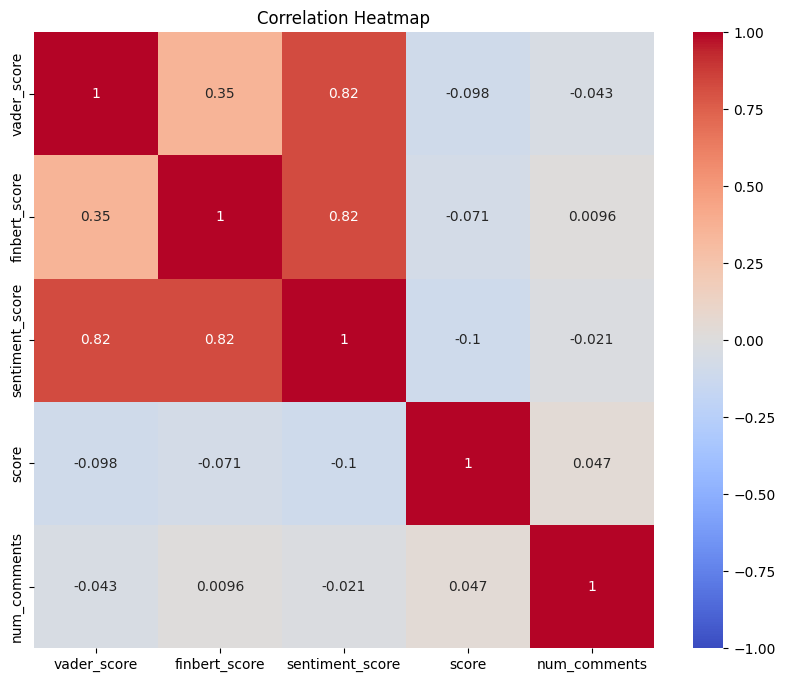

In [ ]:
corr_matrix = reddit_data[['vader_score', 'finbert_score', 'sentiment_score', 'score', 'num_comments']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()